In [4]:
import numpy as np
import time
import scipy
import matplotlib.pyplot as plt
import torch
import h5py
import cv2
import norm
import pylops
import pyproximal
from scipy.sparse import diags, hstack

In [5]:
Training_data_Name = r'E:\03ProgramCode\01Python\02Sem3\MST-plus-plus-master\dataset\Train_spectral\ARAD_1K_0001.mat'
Training_data = h5py.File(Training_data_Name)
print("Keys:", list(Training_data.keys()))

Keys: ['bands', 'cube', 'norm_factor']


In [6]:
cube = np.array(Training_data['cube'])
print(f"'cube' data shape: {cube.shape}")
#print(cube)

'cube' data shape: (31, 512, 482)


In [7]:
bands = np.array(Training_data['bands'])
print(f"'bands' data shape: {bands.shape}")
print(bands.T)

'bands' data shape: (31, 1)
[[400. 410. 420. 430. 440. 450. 460. 470. 480. 490. 500. 510. 520. 530.
  540. 550. 560. 570. 580. 590. 600. 610. 620. 630. 640. 650. 660. 670.
  680. 690. 700.]]


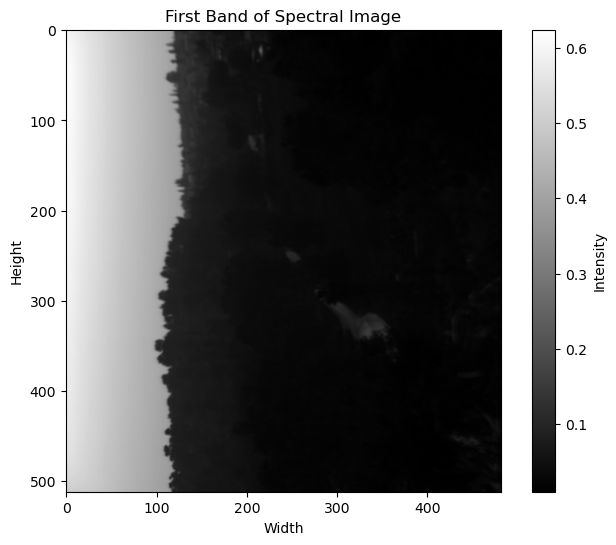

In [10]:
plt.figure(figsize=(8, 6))
plt.imshow(cube[0, :, :], cmap='gray')  # 显示第一个波段的图像，使用灰度图
#plt.gca().invert_yaxis()

plt.title('First Band of Spectral Image')
plt.colorbar(label='Intensity')
plt.xlabel('Width')
plt.ylabel('Height')
plt.show()

Min value of the first normalized matrix: 0.0
Max value of the first normalized matrix: 1.0


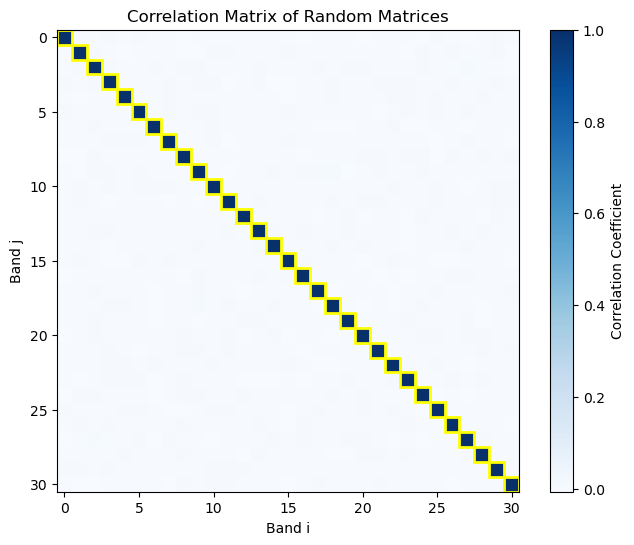

In [3]:
np.random.seed(0)

# 生成 31 个 512x482 的随机矩阵，值符合标准正态分布（均值=0，标准差=1）
num_bands = 31
matrix_size = (482, 482)
random_matrices = [np.random.randn(*matrix_size) for _ in range(num_bands)]
normalized_matrices = [(matrix - matrix.min()) / (matrix.max() - matrix.min()) for matrix in random_matrices]

# 打印归一化后的第一个矩阵的最小值和最大值，验证范围
print("Min value of the first normalized matrix:", normalized_matrices[0].min())
print("Max value of the first normalized matrix:", normalized_matrices[0].max())
# 初始化互相关矩阵
correlation_matrix = np.zeros((num_bands, num_bands))

# 计算每对随机矩阵之间的互相关
for i in range(num_bands):
    for j in range(num_bands):
        # 计算矩阵i和矩阵j的相关系数
        correlation_matrix[i, j] = np.corrcoef(normalized_matrices[i].flatten(), normalized_matrices[j].flatten())[0, 1]

# 绘制互相关矩阵的热力图
plt.figure(figsize=(8, 6))
plt.imshow(correlation_matrix, cmap='Blues', interpolation='nearest')
plt.colorbar(label='Correlation Coefficient')
plt.title('Correlation Matrix of Random Matrices')
plt.xlabel('Band i')
plt.ylabel('Band j')

# 在图像上绘制黄色边框来突出显示大于0.9的相关系数
for i in range(num_bands):
    for j in range(num_bands):
        if correlation_matrix[i, j] > 0.9:
            plt.gca().add_patch(plt.Rectangle((j-0.5, i-0.5), 1, 1, ec='yellow', fc='none', lw=2))

plt.show()

Total intensity matrix shape: (482, 482)


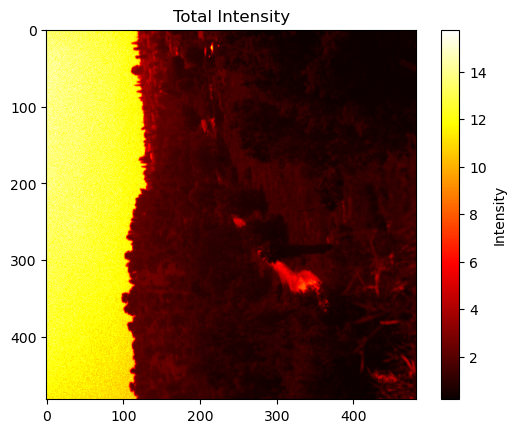

In [7]:
total_intensity = np.zeros((482, 482))
for i in range(num_bands):
    # 将高光谱数据的每个波段与对应的测量矩阵相乘，对应元素相乘
    multiplied_band = cube[i, :482, :] * normalized_matrices[i]
    # 将结果叠加到总强度矩阵
    total_intensity += multiplied_band

# 计算每个像素的总强度
print("Total intensity matrix shape:", total_intensity.shape)

# 显示总强度矩阵
plt.imshow(total_intensity, cmap='hot')
plt.title('Total Intensity')
plt.colorbar(label='Intensity')
plt.show()

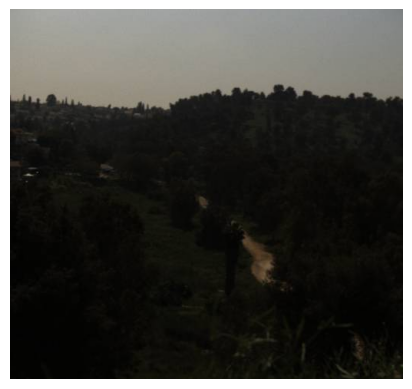

Image shape: (482, 512, 3)


In [8]:
Training_data_Namergb = r'E:\03ProgramCode\01Python\02Sem3\MST-plus-plus-master\dataset\Train_RGB\Train_RGB\ARAD_1K_0001.jpg'
image = cv2.imread(Training_data_Namergb)

# OpenCV 读取的图像是 BGR 格式，需要转换为 RGB 格式显示
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# 显示图像
plt.imshow(image_rgb)
plt.axis('off')  # 关闭坐标轴显示
plt.show()

# 获取图像的尺寸
print(f"Image shape: {image.shape}")

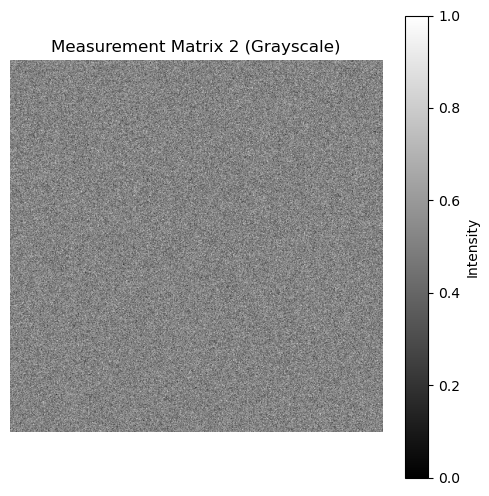

In [5]:
plt.figure(figsize=(6, 6))
plt.imshow(normalized_matrices[2], cmap='gray')
plt.title('Measurement Matrix 2 (Grayscale)')
plt.colorbar(label='Intensity')
plt.axis('off')
plt.show()

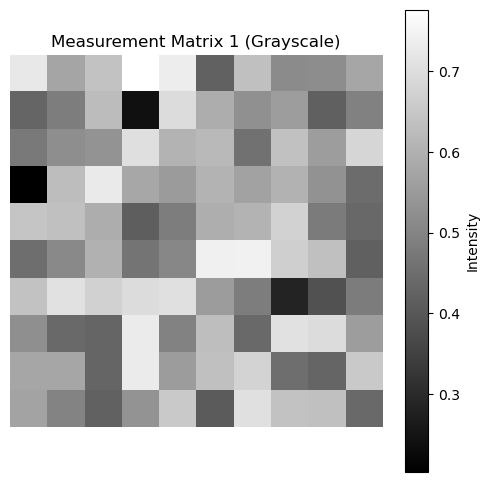

In [66]:
mea_t = np.array(normalized_matrices)
plt.figure(figsize=(6, 6))
plt.imshow(mea_t[0, :10, :10], cmap='gray')
plt.title('Measurement Matrix 1 (Grayscale)')
plt.colorbar(label='Intensity')
plt.axis('off')
plt.show()

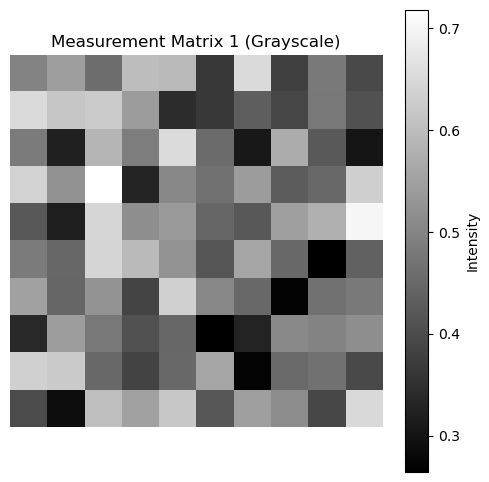

In [67]:
mea_t = np.array(normalized_matrices)
plt.figure(figsize=(6, 6))
plt.imshow(mea_t[1, :10, :10], cmap='gray')
plt.title('Measurement Matrix 1 (Grayscale)')
plt.colorbar(label='Intensity')
plt.axis('off')
plt.show()

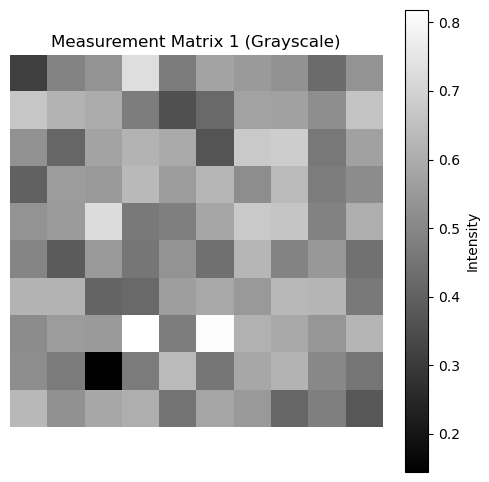

In [68]:

plt.figure(figsize=(6, 6))
plt.imshow(mea_t[2, :10, :10], cmap='gray')
plt.title('Measurement Matrix 1 (Grayscale)')
plt.colorbar(label='Intensity')
plt.axis('off')
plt.show()

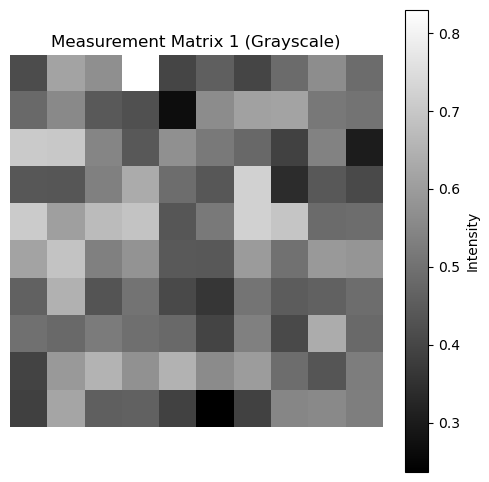

In [69]:
plt.figure(figsize=(6, 6))
plt.imshow(mea_t[3, :10, :10], cmap='gray')
plt.title('Measurement Matrix 1 (Grayscale)')
plt.colorbar(label='Intensity')
plt.axis('off')
plt.show()

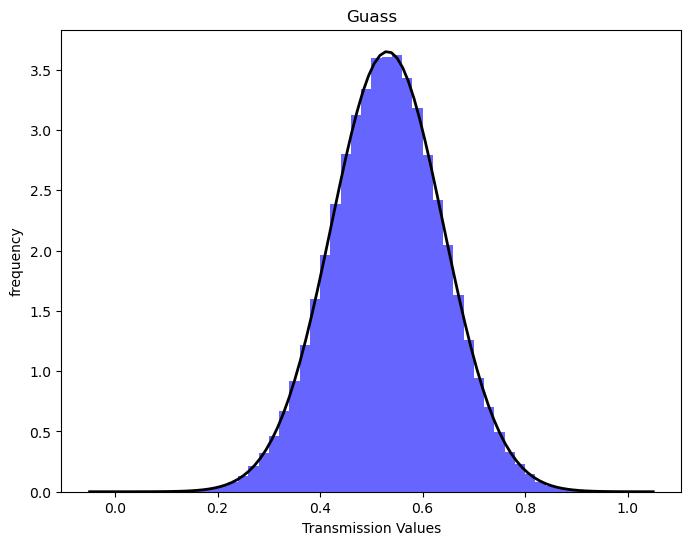

In [10]:
selected_matrix = normalized_matrices[0]

# 展平矩阵的值，合并成一个一维数组
flattened_values = selected_matrix.flatten()

# 计算直方图
plt.figure(figsize=(8, 6))
n, bins, patches = plt.hist(flattened_values, bins=50, density=True, alpha=0.6, color='b')



# 拟合高斯分布
(mu, sigma) = scipy.stats.norm.fit(flattened_values)

# 绘制高斯拟合曲线
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = scipy.stats.norm.pdf(x, mu, sigma)

mu, sigma = scipy.stats.norm.fit(flattened_values)

# 确保高斯拟合曲线的 x 轴范围在 0 到 1 之间
#x = np.linspace(0, 1, 100)
#p = scipy.stats.norm.pdf(x, mu, sigma)

# 绘制高斯拟合曲线
plt.plot(x, p, 'k', linewidth=2)
title = f"Fit results: mu = {mu:.2f},  sigma = {sigma:.2f}"
plt.title(title)
plt.xlabel('Transmission Values')
plt.ylabel('frequency')
plt.title('Guass')
plt.show()

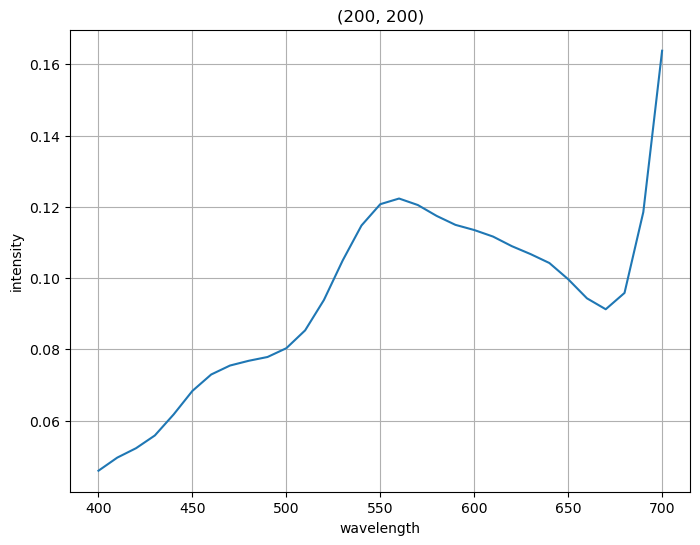

In [11]:
y = cube[:, 200, 200]
x = np.array(Training_data['bands'])
# 绘制图像
plt.figure(figsize=(8, 6))
plt.plot(x, y)
#plt.axhline(0, color='black', linewidth=0.5)
#plt.axvline(0, color='black', linewidth=0.5)
plt.title('(200, 200)')
plt.xlabel('wavelength')
plt.ylabel('intensity')
#plt.legend()
plt.grid(True)
plt.show()

In [21]:
mea_t = np.array(normalized_matrices)
print(mea_t[:, 200, 200])
print(x)

[0.40451214 0.36854433 0.52487505 0.49233599 0.61862588 0.67384169
 0.59359761 0.54777446 0.6575902  0.50043017 0.62040249 0.47922414
 0.48899034 0.36864267 0.40387037 0.53597837 0.31547302 0.51688837
 0.41180851 0.48129555 0.46018503 0.47858798 0.42423444 0.49467206
 0.59892898 0.40853098 0.61037429 0.58750329 0.71136571 0.38467779
 0.63163999]
[[400.]
 [410.]
 [420.]
 [430.]
 [440.]
 [450.]
 [460.]
 [470.]
 [480.]
 [490.]
 [500.]
 [510.]
 [520.]
 [530.]
 [540.]
 [550.]
 [560.]
 [570.]
 [580.]
 [590.]
 [600.]
 [610.]
 [620.]
 [630.]
 [640.]
 [650.]
 [660.]
 [670.]
 [680.]
 [690.]
 [700.]]


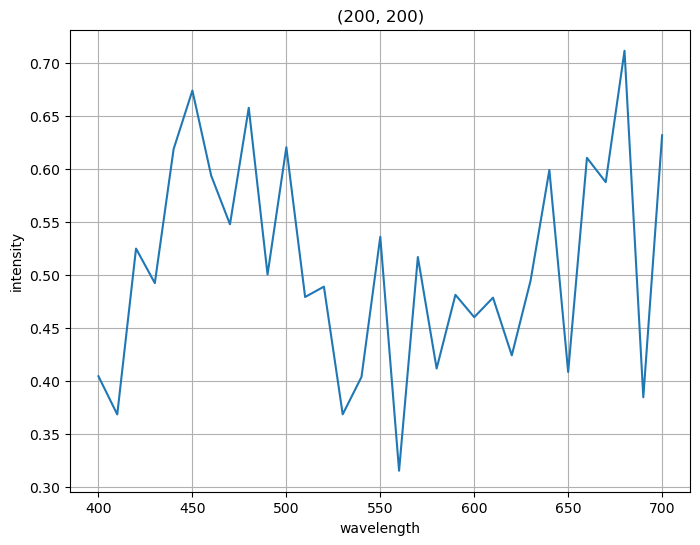

In [33]:
mea_t = np.array(normalized_matrices)
#print(mea_t.shape)
# 绘制图像
plt.figure(figsize=(8, 6))
plt.plot(x, mea_t[:, 200, 200])
#plt.axhline(0, color='black', linewidth=0.5)
#plt.axvline(0, color='black', linewidth=0.5)
plt.title('(200, 200)')
plt.xlabel('wavelength')
plt.ylabel('intensity')
#plt.legend()
plt.grid(True)
plt.show()

In [29]:
# 1. 向量化矩阵（按列展平）
def vectorize_matrix(matrix):
    return matrix.flatten(order='F')  # 列优先展平

# 2. 构建稀疏对角矩阵
def construct_sparse_diag_matrix(vector):
    return diags(vector)

# 3. 构建稀疏大矩阵 K
def construct_sparse_big_matrix(A_list):
    # 先对每个矩阵 A_i 向量化，并构建稀疏对角矩阵
    sparse_diag_matrices = [construct_sparse_diag_matrix(vectorize_matrix(A)) for A in A_list]
    # 然后将所有稀疏对角矩阵水平拼接
    return hstack(sparse_diag_matrices)

# 4. 构建权重向量
def construct_weight_vector(f_list):
    vec_list = [vectorize_matrix(f) for f in f_list]
    return np.concatenate(vec_list, axis=0)

# 5. 从权重向量恢复到原始的三维数据
def restore_matrices_from_vector(x, m, n, N):
    restored_matrices = []
    for i in range(N):
        start_index = i * (m * n)
        end_index = (i + 1) * (m * n)
        vec_f_i = x[start_index:end_index]
        f_i = vec_f_i.reshape((m, n), order='F')
        restored_matrices.append(f_i)
    restored_matrices = np.array(restored_matrices)
    return restored_matrices

In [88]:
def tv_denoising(x, lambda_tv, max_iter=100):
    """在TV域进行去噪"""
    # 这是TV去噪的简单实现。可以用更高级的去噪算法来代替。
    for _ in range(max_iter):
        x = x - lambda_tv * np.gradient(np.gradient(x))
    return x

def block_multiply(Phi, x, m, N):
    """
    使用水平拼接的观测矩阵 Φ 与向量 x 的分块乘法
    :param Phi: 输入的完整观测矩阵，大小为 (m, N * m)
    :param x: 输入向量，长度为 N * m
    :param m: 每个对角块的大小
    :param N: 对角块数量
    :return: 乘法结果，形状与 Φ 的行数相同
    """
    result = np.zeros(Phi.shape[0])  # 结果的行数与 Φ 的行数相同
    
    # 对每个块进行分块运算
    for i in range(N):
        start_x = i * m  # 对应的向量起始位置
        end_x = (i + 1) * m
        
        start_phi = i * m  # 对应的 Φ 块起始列
        end_phi = (i + 1) * m
        
        # 提取 Φ 的第 i 个块，并进行相应的乘法
        block = Phi[:, start_phi:end_phi]
        
        # 只对第 i 个块和向量 x 的第 i 部分进行乘法，并累积到结果中
        result += np.dot(block, x[start_x:end_x])
    
    return result

def twist_algorithm(y, Phi, m, N, omega, lambda_tv, max_iter=100, tol=1e-6):
    # 初始化
    x_0 = np.zeros(Phi.shape[1])  # 初始的 x_0 值
    x_1 = x_0  # 前一次迭代的值
    x = x_0  # 当前估计值
    alpha = 1.0  # α的初始值
    beta = 0.5  # β的初始值
    iteration = 0

    # 开始迭代过程
    while iteration < max_iter:
        # 残差修正：x = x + Φ^T(y - Φx)
        residual = y - block_multiply(Phi, x, m, N)
        x_new = x +  block_multiply(Phi.T, residual, m, N)

        # TV 去噪处理
        x_new = tv_denoising(x_new, lambda_tv)

        # 目标值更新
        x_next = (1 - alpha) * x + (alpha - beta) * x_1 + beta * x_new
        
        # 终止条件
        if np.linalg.norm(x_next - x) < tol:
            print(f"收敛于第 {iteration+1} 次迭代")
            break

        # 更新值
        x_1 = x
        x = x_next
        iteration += 1

    return x

In [86]:
m = 2  # 每个对角矩阵的大小
N = 3  # 对角矩阵的数量

# 随机生成 N 个对角矩阵并水平拼接为大矩阵 Φ
blocks = [np.diag(np.random.rand(m)) for _ in range(N)]
Phi = np.hstack(blocks)  # 将 N 个对角矩阵水平拼接成 Φ

# 打印拼接后的大矩阵 Φ
print("观测矩阵 Φ:")
print(Phi)

# 输入向量 x，长度为 N * m
x = np.random.rand(N * m)

result = block_multiply(Phi, x, m, N)


# 输出结果
print("输入向量 x:", x)
print("分块乘法的结果:", result)
print(result.shape)
print(Phi.shape)

观测矩阵 Φ:
[[0.86990232 0.         0.03913365 0.         0.96376361 0.        ]
 [0.         0.45336201 0.         0.99191959 0.         0.62921262]]
输入向量 x: [0.01639166 0.15279086 0.96235028 0.54706386 0.78972429 0.50809044]
分块乘法的结果: [0.81302695 0.93160985]
(2,)
(2, 6)


In [87]:
print(0.86990232*0.01639166+0.03913365*0.96235028+0.96376361*0.78972429)

0.8130269547326601


In [79]:
y = construct_weight_vector(total_intensity)  # 模拟的观测信号
Phi =  construct_sparse_big_matrix(mea_t) # 随机感知矩阵
omega = 0.1  # 正则化权重
lambda_tv = 0.1  # TV正则化权重
m = 482*482
n = 31*482*482
# 运行TwIST算法
x_reconstructed = twist_algorithm(y, Phi, omega, lambda_tv)

MemoryError: Unable to allocate 27.5 MiB for an array with shape (7202013,) and data type int32

In [77]:
A = np.array([
  [[1, 2, 3],    # 第一个波长的3x3矩阵
   [4, 5, 6],
   [7, 8, 9]],

  [[10, 11, 12], # 第二个波长的3x3矩阵
   [13, 14, 15],
   [16, 17, 18]],

  [[19, 20, 21], # 第三个波长的3x3矩阵
   [22, 23, 24],
   [25, 26, 27]]
])
K = construct_sparse_big_matrix(A)
x = construct_weight_vector(A)
g = np.dot(K, x)
print(x)

[ 1  4  7  2  5  8  3  6  9 10 13 16 11 14 17 12 15 18 19 22 25 20 23 26
 21 24 27]


In [46]:
m = 50
n = 50
#f_list = [np.random.rand(m, n) for _ in range(31)]
f_list = cube[:, 200:250, 200:250]
K = construct_sparse_big_matrix(mea_t[:, 200:250, 200:250])
x = construct_weight_vector(cube[:, 200:250, 200:250])
restored_f_list = restore_matrices_from_vector(x, m, n, len(cube[:, 200:300, 200:250]))

In [55]:
g = np.dot(K,x)
g_t = restore_matrices_from_vector(g, m, n, len(cube[:, 200:300, 200:250]))

In [56]:
print(g.shape)
print(g_t.shape)

(77500,)
(31, 50, 50)


In [47]:
print(mea_t.shape)
print(K.shape)
print(x.shape)
print(restored_f_list.shape)
err = f_list-restored_f_list
print(err[1, :, :])

(31, 482, 482)
(2500, 77500)
(77500,)
(31, 50, 50)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [48]:
#N, M = 15, 20
#A = np.random.randn(N, M)
import gc

gc.collect()
A = K
#A = A / np.linalg.norm(A, axis=0)
Aop = pylops.MatrixMult(A)
Aop.explicit = False  # temporary solution whilst PyLops gets updated

x = construct_weight_vector(cube[:, 200:250, 200:250])
y = total_intensity[200:250, 200:250]

MemoryError: Unable to allocate 605. KiB for an array with shape (77500,) and data type float64

In [14]:
L = np.abs((Aop.H * Aop).eigs(1)[0])
tau = 0.95 / L
eps = 5e-3
maxit = 100

l1 = pyproximal.proximal.L1(sigma=eps)
eigs = (Aop.H * Aop).eigs()
eigs = (np.abs(eigs[0]), 5e-1)
x_twist, costt = \
    pyproximal.optimization.primal.TwIST(l1, Aop, y, eigs=eigs,
                                         x0=np.zeros(M), niter=maxit,
                                         show=False, returncost=True)

In [35]:
tau = 0.95
eps = 5e-3
maxit = 100

Mop = pylops.MatrixMult(mea_t[:, 200, 200])
l1 = pyproximal.proximal.L1(sigma=eps)
x_twist, costt = \
    pyproximal.optimization.primal.TwIST(l1, Mop, total_intensity[200,200], eigs=eigs,
                                         x0=np.zeros(M), niter=maxit,
                                         show=False, returncost=True)

IndexError: tuple index out of range

In [25]:
print(Aop)
print(y)
print(x)
print(A.shape)

<15x20 MatrixMult with dtype=float64>
[-0.26252962 -0.06499724  0.38445917  0.94360992 -0.08973444  0.02075967
 -0.71574727 -0.78431216  0.22892046  0.48942777  0.35467035  0.26017543
 -0.03765584  0.38305299  0.1569487 ]
[0.         0.         0.         0.         0.         0.
 0.         0.95387374 0.         0.         0.         0.
 0.         0.         0.98639039 0.         0.         0.97007799
 0.         0.        ]
(15, 20)


In [15]:
print(x_twist)
print(x)

[ 3.68826637e-02  1.11347162e-08 -6.89174993e-02 -1.80586755e-01
 -1.23968034e-16  1.12454087e-01  3.90988995e-02  6.32518179e-01
  1.52381246e-01  1.08307054e-01 -4.38836464e-02 -3.30657088e-30
 -3.41270017e-03 -9.06276085e-02  6.02028300e-01  4.85060810e-02
  6.78938987e-02  9.28152279e-01  1.05883198e-01  2.16397222e-01]
[0.         0.         0.         0.         0.         0.
 0.         0.95387374 0.         0.         0.         0.
 0.         0.         0.98639039 0.         0.         0.97007799
 0.         0.        ]


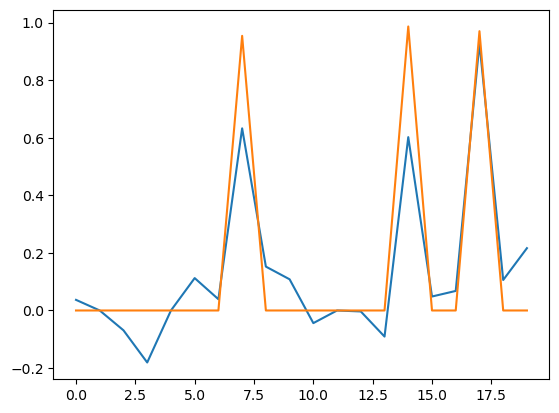

In [18]:
plt.plot(x_twist)
plt.plot(x)

In [78]:
def total_variation(f):
    """Compute the isotropic total variation norm of f."""
    tv = np.sum(np.sqrt(np.diff(f, axis=1, append=f[:, -1:, :])**2 +
                        np.diff(f, axis=2, append=f[:, :, -1:])**2))
    return tv

def soft_thresholding(x, tau):
    """Apply soft-thresholding to x with parameter tau."""
    return np.sign(x) * np.maximum(np.abs(x) - tau, 0)

def twist(y, A, tau, max_iter=1000, tol=1e-5):
    """
    Two-step Iterative Shrinkage/Thresholding (TwIST) algorithm for image reconstruction.

    Parameters:
    y : ndarray
        Measurement data matrix of size (482, 482).
    A : ndarray
        Forward operator matrix of size (31, 482, 482).
    tau : float
        Regularization parameter.
    max_iter : int, optional
        Maximum number of iterations. Default is 1000.
    tol : float, optional
        Tolerance for convergence. Default is 1e-5.
        
    Returns:
    f : ndarray
        Reconstructed image of size (31, 482, 482).
    """

    # Initialize variables
    f = np.zeros_like(A)  # Initial guess for f with shape (31, 482, 482)
    f_old = np.copy(f)
    max_svd = 1.0  # Estimate of the maximum singular value of A
    alpha = 1.0
    beta = 0.5

    for k in range(max_iter):
        # Compute the forward projection of the current estimate
        Af = np.zeros_like(y)  # Initialize Af with the same shape as y (482, 482)
        
        # Calculate sum of A_i * f_i for all bands i
        for i in range(A.shape[0]):  # A.shape[0] == 31
            Af += A[i] * f[i]  # Element-wise multiplication and sum over bands

        # Compute fidelity term (difference between projection and measurement)
        fidelity_term = Af - y  # (482, 482)

        # Compute gradient of the fidelity term for each band
        gradient_fidelity = np.zeros_like(A)
        for i in range(A.shape[0]):
            gradient_fidelity[i] = A[i] * fidelity_term  # Element-wise multiplication for each band

        # Update step for each band of f
        f_new = f - gradient_fidelity

        # Apply total variation regularization (proximal operator)
        for i in range(f.shape[0]):
            f_new[i] = soft_thresholding(f_new[i], tau)

        # Check for convergence
        if np.linalg.norm(f_new - f) / np.linalg.norm(f) < tol:
            print(f"Converged in {k} iterations.")
            break

        # TwIST beta calculation and update
        if k > 0:
            beta = np.dot((f_new - f).ravel(), (f_new - f_old).ravel()) / np.dot((f - f_old).ravel(), (f - f_old).ravel())
            f = f_new + beta * (f_new - f)
        else:
            f = f_new

        f_old = np.copy(f)

    return f

In [79]:
f = twistv1(total_intensity, normalized_matrices, 0.1)

C:\Users\83461\AppData\Local\Temp\ipykernel_41292\716198468.py:45: RuntimeWarning: divide by zero encountered in scalar divide
  if np.linalg.norm(f_new - f) / np.linalg.norm(f) < tol:
C:\Users\83461\AppData\Local\Temp\ipykernel_41292\716198468.py:51: RuntimeWarning: divide by zero encountered in scalar divide
  beta = np.dot((f_new - f).ravel(), (f_new - f_old).ravel()) / np.dot((f - f_old).ravel(), (f - f_old).ravel())
C:\Users\83461\AppData\Local\Temp\ipykernel_41292\716198468.py:41: RuntimeWarning: invalid value encountered in subtract
  f_new = f - gradient_fidelity
C:\Users\83461\AppData\Local\Temp\ipykernel_41292\716198468.py:51: RuntimeWarning: invalid value encountered in subtract
  beta = np.dot((f_new - f).ravel(), (f_new - f_old).ravel()) / np.dot((f - f_old).ravel(), (f - f_old).ravel())


In [80]:
print(f.shape)
print(normalized_matrices[0].shape)

(31, 482, 482)
(482, 482)


In [81]:
print(f[0, :, :])
#print(normalized_matrices[0])
#print(np.sum(normalized_matrices * cube[:, :482, :]))

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


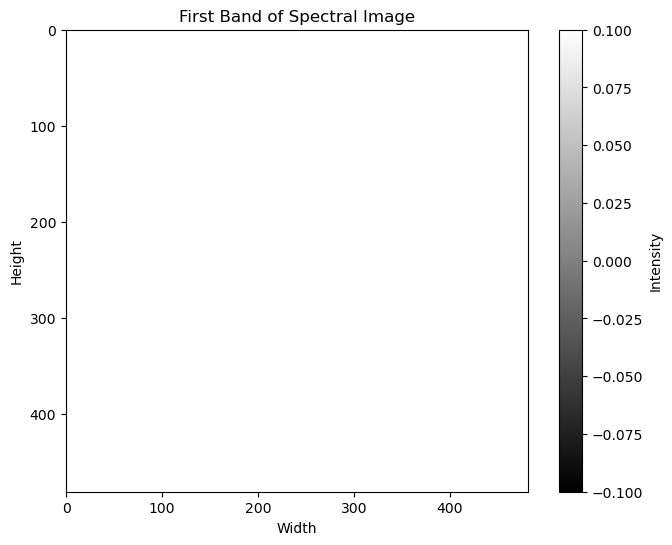

In [71]:
plt.figure(figsize=(8, 6))
plt.imshow(f[0, :, :], cmap='gray')  # 显示第一个波段的图像，使用灰度图
plt.title('First Band of Spectral Image')
plt.colorbar(label='Intensity')
plt.xlabel('Width')
plt.ylabel('Height')
plt.show()

In [ ]:
def twistv1():
    
    return